In [23]:
!pip install kagglehub[pandas-datasets]

Dataset downloaded to: /kaggle/input/cell-images-for-detecting-malaria
Parasitized samples: 13779
Uninfected samples: 13779


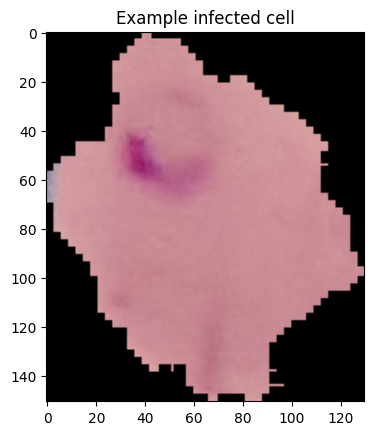

In [24]:
# pip install kagglehub
import kagglehub
import os

# Download the dataset (latest version)
path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")

print("Dataset downloaded to:", path)

# Now you can explore images in the folder
# Example: count files or preview some
import glob

infected_images = glob.glob(os.path.join(path, "cell_images/Parasitized/*.png"))
uninfected_images = glob.glob(os.path.join(path, "cell_images/Uninfected/*.png"))

print("Parasitized samples:", len(infected_images))
print("Uninfected samples:", len(uninfected_images))

# Example: view one image with matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(infected_images[0])
plt.imshow(img)
plt.title("Example infected cell")
plt.show()


In [25]:

import sys

import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from PIL import Image

In [26]:
# Label them and combine
infected = [(path, 1) for path in infected_images]
uninfected = [(path, 0) for path in uninfected_images]
all_data = infected + uninfected

# Split into train/test
train_data, test_data = train_test_split(all_data, test_size=0.2, random_state=42, shuffle=True)

print(f"Train samples: {len(train_data)}, Test samples: {len(test_data)}")

Train samples: 22046, Test samples: 5512


In [27]:
class MalariaDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [28]:
train_transform = transforms.Compose(
    [
      # For Exercise 2 - Add image transforms here before ToTensor()
      transforms.Resize((256, 256)),
      transforms.RandomHorizontalFlip(),
      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

train_dataset = MalariaDataset(train_data, transform=train_transform)
test_dataset = MalariaDataset(test_data, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

class_labels = {0: "Uninfected", 1: "Infected"}
classes = ("Uninfected", "Parasitized")

print("Batches in train:", len(train_loader))

Batches in train: 87


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Parasitized Parasitized Parasitized Parasitized Uninfected Parasitized Parasitized Parasitized


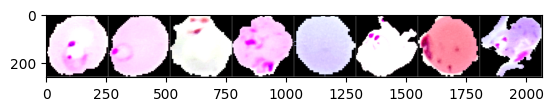

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:8]))

# print labels
print(' '.join('%8s' % classes[labels[j]] for j in range(8)))

In [30]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [31]:
def train_epoch(model, dataloader, device, optimizer, criterion, epoch):
    # We set the model to be in training mode
    model.train()

    total_train_loss = 0.0
    dataset_size = 0

    # This is only for showing the progress bar
    bar = tqdm(enumerate(dataloader), total=len(dataloader), colour='cyan', file=sys.stdout)

    # We iterate through all batches - 1 step is 1 batch of batch_size images
    for step, (images, labels) in bar:
        # We take the images and their labels and push them on GPU
        images = images.to(device)
        labels = labels.to(device)

        batch_size = images.shape[0]

        # Reset gradients
        optimizer.zero_grad()

        # Obtain predictions
        pred = model(images)

        # Compute loss for this batch
        loss = criterion(pred, labels)

        # Compute gradients for each weight (backpropagation)
        loss.backward()

        # Update weights based on gradients (gradient descent)
        optimizer.step()

        # We keep track of the average training loss
        total_train_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = np.round(total_train_loss / dataset_size, 2)
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss)

    return epoch_loss


In [32]:
def valid_epoch(model, dataloader, device, criterion, epoch):
    # We set the model in evaluation mode
    model.eval()

    total_val_loss = 0.0
    dataset_size = 0

    # We keep track of correct predictions
    correct = 0

    # This is only for showing the progress bar
    bar = tqdm(enumerate(dataloader), total=len(dataloader), colour='cyan', file=sys.stdout)

    for step, (images, labels) in bar:
        images = images.to(device)
        labels = labels.to(device)

        batch_size = images.shape[0]

        pred = model(images)
        loss = criterion(pred, labels)

        # The raw output of the model is a score for each class
        # We keep the index of the class with the highest score as the prediction
        _, predicted = torch.max(pred, 1)

        # We see how many predictions match the ground truth labels
        correct += (predicted == labels).sum().item()

        # We compute evaluation metrics - loss and accurarcy
        total_val_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = np.round(total_val_loss / dataset_size, 2)

        accuracy = np.round(100 * correct / dataset_size, 2)

        bar.set_postfix(Epoch=epoch, Valid_Acc=accuracy, Valid_Loss=epoch_loss)

    return accuracy, epoch_loss
     

In [33]:
def run_training(model, criterion, optimizer, num_epochs):
    # Check if we are using GPU
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))

    # For keeping track of the best validation accuracy
    top_accuracy = 0.0

    # We train the emodel for a number of epochs
    for epoch in range(num_epochs):

        train_loss = train_epoch(model, train_loader, device, optimizer, criterion, epoch)

        # For validation we do not keep track of gradients
        with torch.no_grad():
            val_accuracy, val_loss = valid_epoch(model, test_loader, device, criterion, epoch)
            if val_accuracy > top_accuracy:
                print(f"Validation Accuracy Improved ({top_accuracy} ---> {val_accuracy})")
                top_accuracy = val_accuracy
        print()

In [34]:
def findConv2dOutShape(hin,win,conv,pool=2):
    # get conv arguments
    kernel_size = conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

In [35]:
class CNN_MALARIA(nn.Module):

    def __init__(self, params):

        super(CNN_MALARIA, self).__init__()

        Cin,Hin,Win = params["shape_in"]
        init_f = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]

        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)

        self.num_flatten=h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

        self.activation = nn.GELU()

    def forward(self,X):

        X = self.activation(self.conv1(X));
        X = F.max_pool2d(X, 2, 2)
        X = self.activation(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = self.activation(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = self.activation(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, self.num_flatten)
        X = self.activation(self.fc1(X))
        X = F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

In [36]:
params_model={
        "shape_in": (3,256,256),
        "initial_filters": 8,
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 2}


model = CNN_MALARIA(params_model)
model.to(device)

CNN_MALARIA(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=12544, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
  (activation): GELU(approximate='none')
)

In [37]:
# Hyperparameters
learning_rate = 0.002
epochs = 5

# Loss - dependinng on the task you should change this
criterion = nn.CrossEntropyLoss()

# Adam is an improved gradient descent algorithm
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

In [38]:
run_training(model, criterion, optimizer, epochs)

[INFO] Using GPU: Tesla T4

100%|██████████| 22/22 [01:18<00:00,  3.56s/it, Epoch=0, Valid_Acc=95.5, Valid_Loss=0.16]
Validation Accuracy Improved (0.0 ---> 95.45)

100%|██████████| 22/22 [00:26<00:00,  1.21s/it, Epoch=1, Valid_Acc=95.9, Valid_Loss=0.14]
Validation Accuracy Improved (95.45 ---> 95.88)

100%|██████████| 22/22 [00:23<00:00,  1.05s/it, Epoch=2, Valid_Acc=96, Valid_Loss=0.14]  
Validation Accuracy Improved (95.88 ---> 96.03)

100%|██████████| 22/22 [00:25<00:00,  1.14s/it, Epoch=3, Valid_Acc=95.4, Valid_Loss=0.14]

100%|██████████| 22/22 [00:27<00:00,  1.23s/it, Epoch=4, Valid_Acc=95.7, Valid_Loss=0.16]

